# Implementation of Machine Learning models

- Loading and preparing data 
- Multiple model analysis
- Model Selection
- Model Validation with validation data
- Model Evaluation with test data
- Model Tuning using GridSearch method
- API testing and idea

# 1-Importing Key Modules

In [2]:
# support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

# I am an engineer. I care only about error not warning. So, let's be maverick and ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [3]:
import re    # for regular expressions 
import nltk  # for text manipulation 
import string 
import numpy as np 
import pandas as pd 

#For Visuals
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [4]:
#models and evaluation

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from nltk.classify.scikitlearn import SklearnClassifier # notice its from ntlk not sklearn
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
# Evaluation packages
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [5]:
# testing GPU on colab
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# 2)-Loading data

In [6]:
data=pd.read_csv('train_data_10000.csv')
data=data.rename(columns={'Unnamed: 0':'random_columns'}) # a trick to tackle random index values
data=data.drop(["random_columns"], axis=1)
data.shape

(10000, 2)

In [7]:
data.head(2)

,news,category
0,Top 5 Reasons Why 'Divergent' Star Kate Winsle...,e
1,Vessyl Bottle Tracks Your Drink And Its Health...,t


In [8]:
data.isnull().sum()

news        0
category    0
dtype: int64

# 3-Data Cleaning

In [9]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;#]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z +_]')
STOPWORDS = stopwords.words('english')
#STOPWORDS.extend(['http','https','www']) # extend stopwords. If We  had few www or https.
STOPWORDS = set(STOPWORDS)

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join([word for word in text.split() if word not in STOPWORDS]) # delete stopwords from text
    text = text.strip()
    return text

In [11]:
data['clean']=[text_prepare(x) for x in data['news']]

In [12]:
# Dictionary of all words from train corpus with their counts.
words_counts = {}

from collections import Counter
words_counts = Counter([word for line in data['clean'] for word in line.split(' ')])

# Sorting 
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Top 10
most_common_words[:10]

[('news', 998),
 ('new', 655),
 ('times', 522),
 ('blog', 442),
 ('us', 422),
 ('business', 318),
 ('daily', 316),
 ('post', 296),
 ('google', 266),
 ('apple', 221)]

### 3.1.Lemma
Normalize

In [13]:
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()

In [14]:
tokenized_text = data['clean'].apply(lambda x: x.split()) # tokenizing 
print(tokenized_text[9])

['could', 'ted', 'lawsuit', 'keep', 'ted', '2', 'happeningmoviefone']


In [15]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
tokenized_text = tokenized_text.apply(lambda x: [lemm.lemmatize(i) for i in x])
print(tokenized_text[2])

['conjoined', 'twin', 'leave', 'dallas', 'hospital', 'month', 'separated', 'tribune']


### 3.2.using stemmer

In [17]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer(language='english')

In [18]:
tokenized_text = data['clean'].apply(lambda x: x.split()) # tokenizing 
tokenized_text = tokenized_text.apply(lambda x: [stemmer.stem(i) for i in x])
print(tokenized_text[2])

['conjoin', 'twin', 'leav', 'dalla', 'hospit', 'month', 'separ', 'tribun']


In [19]:
# stitch these tokens back together.

for i in range(len(tokenized_text)):
    tokenized_text[i] = ' '.join(tokenized_text[i])    
data['clean'] = tokenized_text

In [20]:
#before clean
data['news'].apply(lambda x: len(x.split(' '))).sum()

103496

In [21]:
#after clean
data['clean'].apply(lambda x: len(x.split(' '))).sum()

81669

### save for future work

In [22]:
#data.to_csv('train_data_clean.csv',index=False)

# 4-Model Building

In [23]:
#Function for category id
data['category_id'] = data['category'].factorize()[0]
category_id_df = data[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)

In [24]:
#vectorization
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(data.clean).toarray()
labels = data['category'].astype(str)

In [25]:
print(features.shape)
print(labels.shape)

(10000, 3438)
(10000,)


In [26]:
# model fit

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC 
from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [27]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.7960
1,RandomForestClassifier,1,0.8110
2,RandomForestClassifier,2,0.7920
3,RandomForestClassifier,3,0.7905
4,RandomForestClassifier,4,0.7950
5,LinearSVC,0,0.8520
6,LinearSVC,1,0.8505
7,LinearSVC,2,0.8430
8,LinearSVC,3,0.8470
9,LinearSVC,4,0.8525


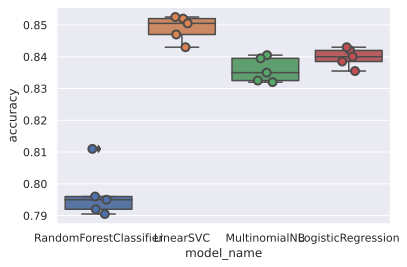

In [28]:
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [29]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.8490
LogisticRegression        0.8398
MultinomialNB             0.8359
RandomForestClassifier    0.7969
Name: accuracy, dtype: float64

# 5- Model Performance with validation method

In [30]:
print(features.shape)
print(labels.shape)

(10000, 3438)
(10000,)


Mathematically, optimizing an SVM is a convex optimization problem, usually with a unique minimizer. This means that there is only one solution to this mathematical optimization problem.

The differences in results come from several aspects: SVC and LinearSVC are supposed to optimize the same problem, but in fact all liblinear estimators penalize the intercept, whereas libsvm ones don't (IIRC). This leads to a different mathematical optimization problem and thus different results. There may also be other subtle differences such as scaling and default loss function (edit: make sure you set loss='hinge' in LinearSVC). 

**in multiclass classification, linearSVC does one-vs-rest by default whereas SVC does one-vs-one.**

SGDClassifier(loss='hinge') is different from the other two in the sense that it uses stochastic gradient descent and not exact gradient descent and may not converge to the same solution. However the obtained solution may generalize better.

Between SVC and LinearSVC, one important decision criterion is that LinearSVC tends to be faster to converge the larger the number of samples is. This is due to the fact that the linear kernel is a special case, which is optimized for in Liblinear, but not in Libsvm

In [32]:
from sklearn.svm import SVC 
model_val = LinearSVC() # using best performing model
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, data.index, test_size=0.20, random_state=0)
model_val.fit(X_train, y_train) # training on whole train data

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [33]:
y_pred = model_val.predict(X_test)


In [34]:
training_scr=model_val.score(X_train, y_train)
print('model Accuracy for train data: ',training_scr)

model Accuracy for train data:  0.96425


In [35]:
import sklearn.metrics as metrics
print('Model Accuracy for validation data: ', metrics.accuracy_score(y_test,y_pred))

Model Accuracy for validation data:  0.8455


Results are pretty same in number as LinearSVC and SVC. Mathematical difference is stated above.

There is clear sign of overfitting. We need to counter this problem.

In [36]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           b       0.81      0.81      0.81       530
           e       0.90      0.92      0.91       731
           m       0.79      0.73      0.76       222
           t       0.84      0.83      0.83       517

    accuracy                           0.85      2000
   macro avg       0.83      0.82      0.83      2000
weighted avg       0.84      0.85      0.84      2000



Consistent with Cross validation analysis above. Let's see how it performs on test data i.e data with only headline title.

# 6-Evaluation

In [38]:
# fit model over 10K samples now.
model_ml = LinearSVC()
model_ml.fit(features, labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

### 6.1.Serialize model

In [39]:
# save the model to disk
import pickle
save_model = 'linearsvc_model.sav'
pickle.dump(model_ml, open(save_model, 'wb'))

In [40]:
save_vect = 'tfidf.sav'
pickle.dump(tfidf, open(save_vect, 'wb'))

### 6.2.checking on test data

In [41]:
#loading test feature and label data saved from previous notebooks
feature_test=pd.read_csv('test_data.csv')
label_test=pd.read_csv('test_label.csv')

In [42]:
print(feature_test.shape)
print(label_test.shape)

(84484, 2)
(84484, 1)


In [43]:
feature_test.head(2)

,Unnamed: 0,title
0,153245,iPhone 6 Release Date Pushed Back Due to Issue...
1,308611,Samsung Galaxy S4 vs Galaxy S3: Budget-Friendl...


In [44]:
# use save tfidf , also I only transformed NOT fit method
features_test = tfidf.transform(feature_test.title).toarray()

In [45]:
print(features_test.shape)

(84484, 3438)


In [46]:
y_pred = model_ml.predict(features_test)
print(y_pred.shape)

(84484,)


In [47]:
training_scr=model_ml.score(features, labels)
print('model Accuracy for train data: ',training_scr)

model Accuracy for train data:  0.9572


In [48]:
from sklearn.metrics import accuracy_score
print('Model Accuracy for test data: ', metrics.accuracy_score(label_test,y_pred))

Model Accuracy for test data:  0.7642038729226835


Again we can see an overfitting in results

In [49]:
y_pred[:5]

array(['e', 't', 'e', 'm', 'b'], dtype=object)

### 6.3. Confusion Matrix

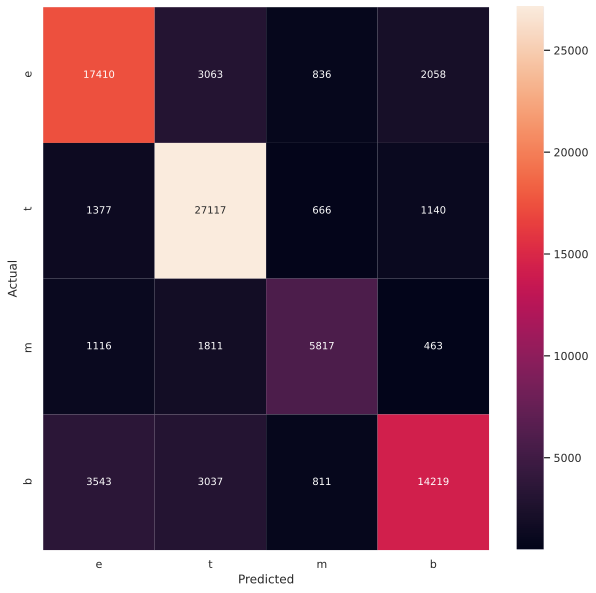

In [50]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(label_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### 6.4.Classification Report

In [51]:
from sklearn import metrics
print(metrics.classification_report(label_test, y_pred))

              precision    recall  f1-score   support

           b       0.74      0.75      0.74     23367
           e       0.77      0.89      0.83     30300
           m       0.72      0.63      0.67      9207
           t       0.80      0.66      0.72     21610

    accuracy                           0.76     84484
   macro avg       0.76      0.73      0.74     84484
weighted avg       0.76      0.76      0.76     84484



In [52]:
print(labels.nunique())
print(label_test.nunique())

4
category    4
dtype: int64


# 7-Model Tune

In [ ]:
from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['linear', 'rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(features, labels) 

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.732, total= 8.4min
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.4min remaining:    0.0s


[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.722, total= 8.3min
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 16.7min remaining:    0.0s


[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.722, total= 8.4min
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.725, total= 8.4min
[CV] C=0.1, gamma=1, kernel=linear ...................................


This is taking like ages and my colab book has restarted twice. So, I will leave it here. 

In [ ]:
# save the model to disk
import pickle
save_model = 'grid_model.sav'
pickle.dump(grid, open(save_model, 'wb'))

In [ ]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

In [ ]:
grid_predictions = grid.predict(X_test) 

In [ ]:
training_scr=grid.score(features, labels)
print('model Accuracy for train data: ',training_scr)

In [ ]:
print('Model Accuracy for test data: ', metrics.accuracy_score(label_test,grid_predictions))

In [ ]:
# print classification report 
print(classification_report(label_test, grid_predictions))

# 8-api idea
key: text <br>
output1: class prediction <br>
output2: probability of each class (higher is better) <br>

In [ ]:
filename = 'linearsvc_model.sav'
model_ml = pickle.load(open(filename, 'rb'))

In [ ]:
filename2 = 'tfidf.sav'
tfidf = pickle.load(open(filename2, 'rb'))

In [ ]:
texts=["YouTube updates to include crowd-funding options"]

In [ ]:
text_features = tfidf.transform(texts)
pred_class = model_ml.predict(text_features)
score=model_ml._predict_proba_lr(text_features)

In [ ]:
pd.DataFrame(model_ml._predict_proba_lr(text_features), columns=model1.classes_)

,b,e,m,t
0,0.317146,0.320885,0.200135,0.161834


In [ ]:
prob=score.max(axis=1)
prob

array([0.3208853])

In [ ]:
result=texts
result=pd.DataFrame(result,columns=["newsheadline"])
result["news-type"]=pred_class
result["probability"]=prob

In [ ]:
result

,text,news-type,probability
0,YouTube updates to include crowd-funding options,e,0.320885


In [ ]:
json_img = result.to_json(orient='records')  
json_img

'[{"text":"YouTube updates to include crowd-funding options","news-type":"e","probability":0.3208852961}]'